## Plot comparisons of total column ozone for specific months

In this exercise you will read-in various total column ozone (TCO) datasets from a variety of sources:

1. Observations from Bodeker Scientific
2. Processed UKCA data submitted to phase 1 of the Chemistry-Climate Model Initative (CCMI1)
3. A ensemble of processed UKCA submitted to CCMI2022
4. UM-UKCA pp-file output run as part of the NERC ACSIS project

Some example plots will be given, along with suggested exercises for you to complete.

In [1]:
import iris
import iris.quickplot as qplt
import iris.coord_categorisation
import iris.analysis
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
iris.FUTURE.date_microseconds = True

In [2]:
# UKCA model data from ACSIS project, nudged to ERA5
ukcadata='/home/ubuntu/Tutorials/UMvn13.0/data/u-*/apm.pp/*.pp'
# Bodeker Scientific TCO dataset - https://www.bodekerscientific.com/data/total-column-ozone
# this has been preprocessed into a single file using ncks, ncatted, and ncrcat
# for i in `ls *.nc`; do echo $i; ncks -O --mk_rec_dmn time $i $i; done
# for i in `ls *.nc`; do echo $i; ncatted -O -a created,global,d,, $i; done
# for i in `ls *.nc`; do echo $i; ncatted -O -a units,longitude,o,c,degrees_east $i; done
# for i in `ls *.nc`; do echo $i; ncatted -O -a units,latitude,o,c,degrees_north $i; done
# ncrcat BSFilledTCO_V3.4.1_????_Monthly.nc ../BSFilledTCO_V3.4.1_Monthly.nc
obsdata='/home/ubuntu/Tutorials/UMvn13.0/data/Bodeker_3.4.1/*.nc'
# We would like to thank Bodeker Scientific, funded by the New Zealand Deep South National 
# Science Challenge, for providing the combined NIWA-BS total column ozone database.

In [3]:
# time constraint for loading, want March 2011 for the northern hemisphere
imonth=3
iyear=2011
ilat=90.0

# time constraints for extracting data
pdt1=iris.time.PartialDateTime(year=iyear, month=imonth, day=1)
pdt2=iris.time.PartialDateTime(year=iyear, month=imonth+1, day=1)
tconstr=iris.Constraint(time=lambda cell: pdt1 <= cell.point < pdt2)

In [4]:
# pp-files for UKCA, individual files
ukca=iris.load_cube(ukcadata,tconstr & iris.AttributeConstraint(STASH='m01s50i219'))

# Bodeker Total Column Ozone dataset - **preprocessed**
obs=iris.load_cube(obsdata,'equivalent_thickness_at_stp_of_atmosphere_ozone_content' & tconstr)

/home/vagrant/.conda/envs/ukca/lib/python3.12/site-packages/iris/fileformats/rules.py:371: IrisUserWarning: Unable to create instance of HybridHeightFactory. The source data contains no field(s) for 'orography'.
  warnings.warn(


In [5]:
# add year and month information
iris.coord_categorisation.add_month_fullname(ukca,'time')
iris.coord_categorisation.add_year(ukca,'time')
iris.coord_categorisation.add_month_fullname(obs,'time')
iris.coord_categorisation.add_year(obs,'time')

In [6]:
# set contour levels for use in plots
clevs=np.arange(200,475,25)

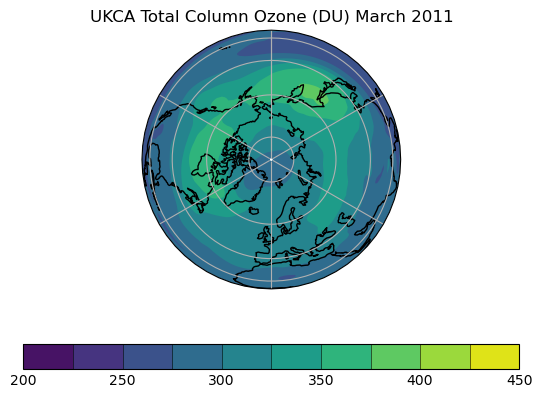

In [7]:
# set the projection to look over the north pole
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=ilat)
ax = plt.axes(projection=proj)
qplt.contourf(ukca, clevs)
plt.gca().coastlines()
ax.gridlines()
plt.title('UKCA Total Column Ozone (DU) '+ukca.coord('month_fullname').points[0]+' '+str(ukca.coord('year').points[0]))
plt.show()

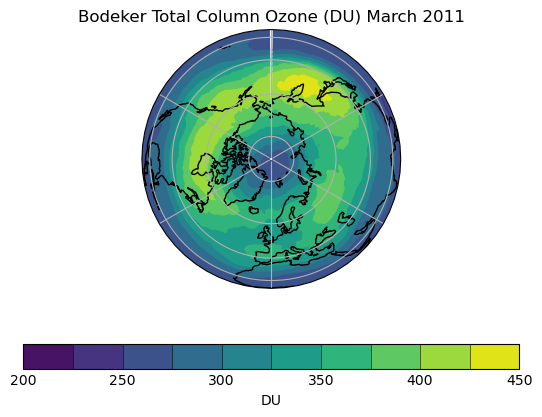

In [8]:
# set the projection to look over the north pole
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=ilat)
ax = plt.axes(projection=proj)
qplt.contourf(obs, clevs)
plt.gca().coastlines()
ax.gridlines()
plt.title('Bodeker Total Column Ozone (DU) '+obs.coord('month_fullname').points[0]+' '+str(obs.coord('year').points[0]))
plt.show()

In [9]:
# regrid the UKCA to the Bodeker grid to allow for differencing
# ensure are using the same coordinate system
ukca.coord(axis='X').coord_system=obs.coord_system()
ukca.coord(axis='Y').coord_system=obs.coord_system()

# guess the bounds
if not ukca.coord(axis='X').has_bounds():
    ukca.coord(axis='X').guess_bounds()
if not ukca.coord(axis='Y').has_bounds():
    ukca.coord(axis='Y').guess_bounds()
    
# now regrid using bilinear
ukca_regrid=ukca.regrid(obs,iris.analysis.Linear())

In [10]:
# calculate differences
# absolute
diff_abs=ukca_regrid.copy()
diff_abs.data=ukca_regrid.data - obs.data
# percentage
diff_pc=ukca_regrid.copy()
diff_pc.data=100.0*((ukca_regrid.data - obs.data)/obs.data)

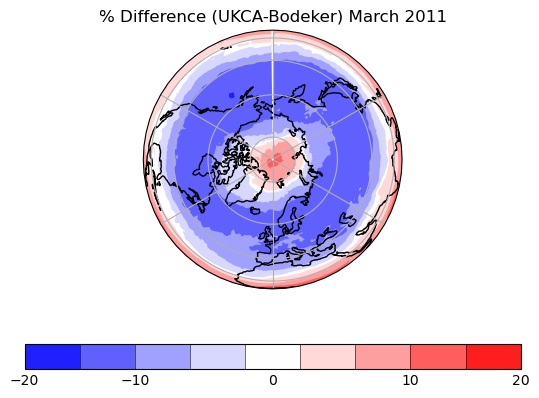

In [11]:
# levels for plotting
clevs=np.array([-20,-15,-10,-5,-1,1,5,10,15,20])
# set the projection to look over the north pole
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=ilat)
ax = plt.axes(projection=proj)
cplot=qplt.contourf(diff_pc, clevs, cmap=cm.bwr)
plt.gca().coastlines()
ax.gridlines()
plt.title('% Difference (UKCA-Bodeker) '+ukca_regrid.coord('month_fullname').points[0]+' '+str(ukca_regrid.coord('year').points[0]))
cplot.colorbar.set_ticks([-20,-10,0,10,20])
plt.show()

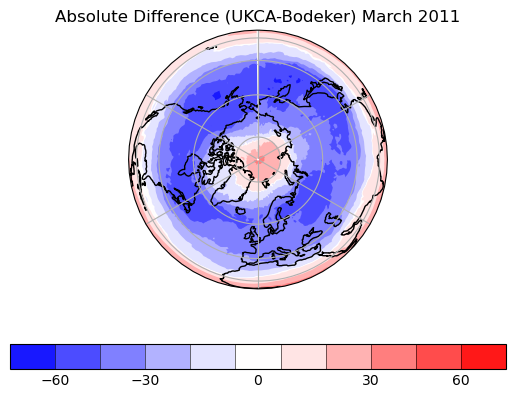

In [12]:
# levels for plotting
clevs=np.array([-75,-60,-45,-30,-15,-1,1,15,30,45,60,75])
# set the projection to look over the north pole
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=ilat)
ax = plt.axes(projection=proj)
cplot=qplt.contourf(diff_abs, clevs, cmap=cm.bwr)
plt.gca().coastlines()
ax.gridlines()
plt.title('Absolute Difference (UKCA-Bodeker) '+ukca_regrid.coord('month_fullname').points[0]+' '+str(ukca_regrid.coord('year').points[0]))
cplot.colorbar.set_ticks([-60,-30,0,30,60])
plt.show()

### Further exercises to try:

1. Try plotting different dates, e.g. September 2002 over the south pole
2. How do the CCMI1 and CCMI2022 similations compare. Rather than individual months, try considering decadal climatologies and compare ensemble members.